In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# Merge these two dataframes along the stay_id column.
df=pd.read_csv('train.csv')


In [40]:
#First look at the data.
df.describe()

,index,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,day_of_week_intime,stay_length_hours
count,329067.000000,3.290670e+05,3.290670e+05,310494.000000,315563.000000,313025.000000,312841.000000,314583.000000,314065.000000,323555.000000,329067.000000,329067.000000
mean,212524.629237,1.500888e+07,3.499692e+07,98.088456,85.058586,17.560933,98.371442,134.964673,81.678586,2.616662,3.000547,7.242123
std,122709.929669,2.879797e+06,2.888285e+06,0.977548,18.145794,2.534146,2.475737,22.698004,1197.493036,0.709372,2.003170,6.570937
min,0.000000,1.000003e+07,3.000001e+07,82.400000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,106307.500000,1.251744e+07,3.249907e+07,97.600000,72.000000,16.000000,97.000000,120.000000,68.000000,2.000000,1.000000,3.602500
50%,212441.000000,1.501416e+07,3.499179e+07,98.000000,84.000000,18.000000,99.000000,133.000000,77.000000,3.000000,3.000000,5.533333
75%,318828.000000,1.750440e+07,3.750427e+07,98.600000,96.000000,18.000000,100.000000,148.000000,87.000000,3.000000,5.000000,8.400000
max,425086.000000,1.999999e+07,3.999996e+07,110.000000,1228.000000,209.000000,100.000000,948.000000,661672.000000,5.000000,6.000000,192.566667


In [41]:
#Check how many missing values there are for each variable. 
df.isna().sum()

index                     0
subject_id                0
stay_id                   0
intime                    0
outtime                   0
gender                    0
race                      0
arrival_transport         0
temperature           18573
heartrate             13504
resprate              16042
o2sat                 16226
sbp                   14484
dbp                   15002
pain                  10159
acuity                 5512
chiefcomplaint           14
day_of_week_intime        0
time_of_day_intime        0
stay_length_hours         0
dtype: int64

In [42]:
#Investigate this more by checking how these missing values are distributed. The following compute the number of missing values 
# in each row and then looks at the distribution of this count. It appears that for all but 4 cases, we have at least partial information
# for the triage variables. This makes it reasonble to do some kind of imputation here.
df.isna().sum(axis=1).value_counts()

0    300858
1     12179
6      5748
8      5301
2      2022
7      1554
3       568
5       447
4       386
9         4
Name: count, dtype: int64

,count,mean,std,min,25%,50%,75%,max
day_of_week_intime,,,,,,,,
0,47306.0,7.213648,6.567306,0.0,3.600000,5.500000,8.366667,188.100000
1,46907.0,7.247104,6.499170,0.0,3.616667,5.550000,8.383333,161.283333
2,46672.0,7.224490,6.452825,0.0,3.619444,5.550000,8.383333,182.605556
3,47141.0,7.237177,6.654173,0.0,3.600000,5.533333,8.366667,139.583333
4,46856.0,7.282775,6.544539,0.0,3.616667,5.550000,8.466667,192.566667
5,46827.0,7.266800,6.700001,0.0,3.583333,5.533333,8.400000,178.666667
6,47358.0,7.223313,6.574561,0.0,3.616667,5.533333,8.394583,136.666667


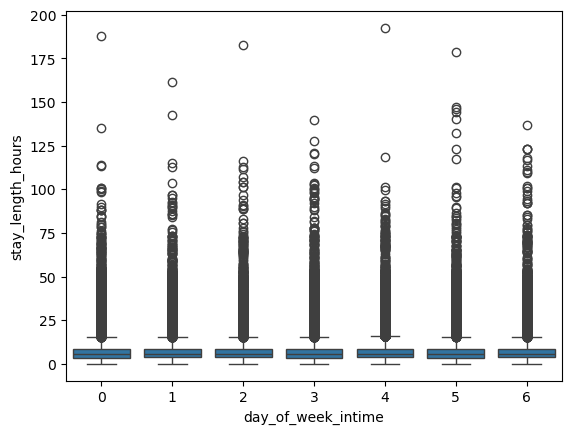

In [ ]:
#Looking at stay length, grouped by day of the week for intime. It does not appear that there is any connection, looking at the summary measures.

sns.boxplot(x='day_of_week_intime',y='stay_length_hours', data=df)
df.groupby('day_of_week_intime')['stay_length_hours'].describe()


,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
F,178505.0,7.252899,6.380044,0.0,3.700000,5.60,8.383333,178.666667
M,150562.0,7.229347,6.790309,0.0,3.507083,5.45,8.400000,192.566667


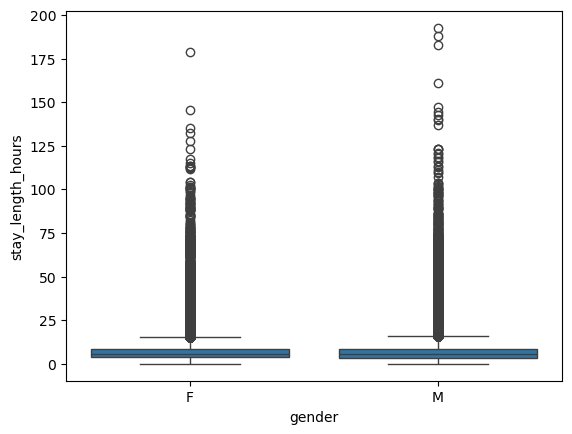

In [43]:
#Looking at stay length, grouped by gender. 

sns.boxplot(x='gender',y='stay_length_hours', data=df)
df.groupby('gender')['stay_length_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
AMERICAN INDIAN/ALASKA NATIVE,813.0,7.755624,8.143871,0.050000,3.700000,5.566667,8.500000,81.916667
ASIAN,5781.0,6.438503,6.332053,0.083333,3.110000,4.866667,7.366667,123.133333
ASIAN - ASIAN INDIAN,1198.0,6.573049,5.788528,0.000000,3.200000,5.066667,7.650000,57.933333
ASIAN - CHINESE,5801.0,6.847058,5.814411,0.016667,3.516667,5.383333,8.066667,75.583333
ASIAN - KOREAN,642.0,5.954566,5.364532,0.066667,3.001319,4.666667,7.129167,62.766667
ASIAN - SOUTH EAST ASIAN,1219.0,7.130775,5.926663,0.116667,3.708333,5.450000,8.333333,52.566667
BLACK/AFRICAN,3788.0,7.325149,6.859054,0.050000,3.450000,5.400000,8.531667,117.200000
BLACK/AFRICAN AMERICAN,58673.0,7.403273,7.001473,0.000000,3.600000,5.581389,8.583333,188.100000
BLACK/CAPE VERDEAN,5955.0,6.553785,5.313040,0.116667,3.483333,5.233333,7.766667,77.050000


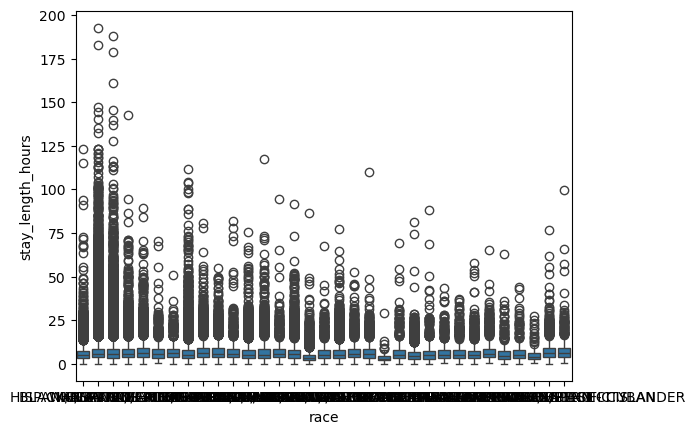

In [44]:
#Looking at stay length, grouped by race. There does seem to be substantial variation across racial categories, 
# but it does not line up nicely with the hierarchy of the categories. For example, note that stay lengths are shorter, generally for "Hispanic or Latino" 
#compareed to the various 'Hispanic/Latino' subcategories.
sns.boxplot(x='race',y='stay_length_hours', data=df)
df.groupby('race')['stay_length_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
arrival_transport,,,,,,,,
AMBULANCE,122641.0,8.349589,7.313820,0.000000,4.283333,6.335833,9.616667,161.283333
HELICOPTER,697.0,4.734418,3.651726,0.200000,2.550000,3.866667,5.700000,29.700000
OTHER,1004.0,8.124344,10.273060,0.417222,3.308333,5.433333,8.512500,188.100000
UNKNOWN,7454.0,3.741812,3.459933,0.000000,1.728194,3.166667,4.950000,79.100000
WALK IN,197271.0,6.690256,6.014698,0.000000,3.350000,5.166667,7.783333,192.566667


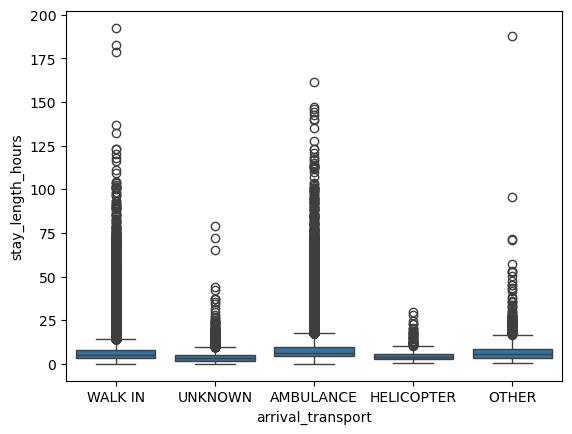

In [45]:
#Looking at stay length, grouped by arrival transport. There are significant differences here.
sns.boxplot(x='arrival_transport',y='stay_length_hours', data=df)
df.groupby('arrival_transport')['stay_length_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
acuity,,,,,,,,
1.0,19043.0,6.079679,4.947033,0.0,3.340000,4.883333,7.133333,109.966667
2.0,109268.0,8.625332,7.874449,0.0,4.366667,6.400000,9.666667,192.566667
3.0,172720.0,7.070320,5.869828,0.0,3.716667,5.566667,8.283333,182.605556
4.0,21725.0,3.520008,3.548807,0.0,1.866667,2.750000,4.033333,113.016667
5.0,799.0,2.449448,3.027304,0.0,1.016667,1.833333,2.750000,36.716667


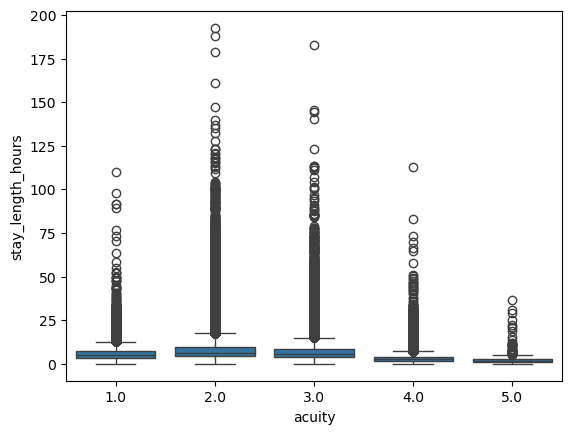

In [46]:
#Acuity is a ranking by a registered nurse based on the Emergency Severity Index (ESI). See details here: https://mimic.mit.edu/docs/iv/modules/ed/triage/ 
#It looks like this has a reasonably strong (but not monotonic) relationship.
sns.boxplot(x='acuity',y='stay_length_hours', data=df)
df.groupby('acuity')['stay_length_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
pain,,,,,,,,
6-9,1.0,7.433333,NaN,7.433333,7.433333,7.433333,7.433333,7.433333
0,8.0,8.371806,7.851692,2.094167,4.332569,5.325000,9.375000,25.866667
10,3.0,5.855556,1.879741,4.600000,4.775000,4.950000,6.483333,8.016667
4,1.0,5.383333,NaN,5.383333,5.383333,5.383333,5.383333,5.383333
6,1.0,9.266667,NaN,9.266667,9.266667,9.266667,9.266667,9.266667
...,...,...,...,...,...,...,...,...
yelling,1.0,5.831944,NaN,5.831944,5.831944,5.831944,5.831944,5.831944
yes,86.0,8.116993,5.560346,0.833333,4.325000,6.975000,9.620833,29.366667
yes,1.0,11.733333,NaN,11.733333,11.733333,11.733333,11.733333,11.733333


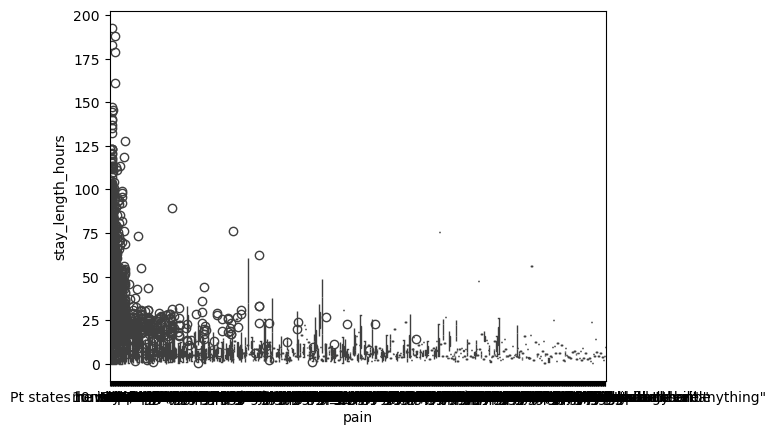

In [49]:
sns.boxplot(x='pain',y='stay_length_hours', data=df)
df.groupby('pain')['stay_length_hours'].describe()

<Axes: xlabel='temperature', ylabel='stay_length_hours'>

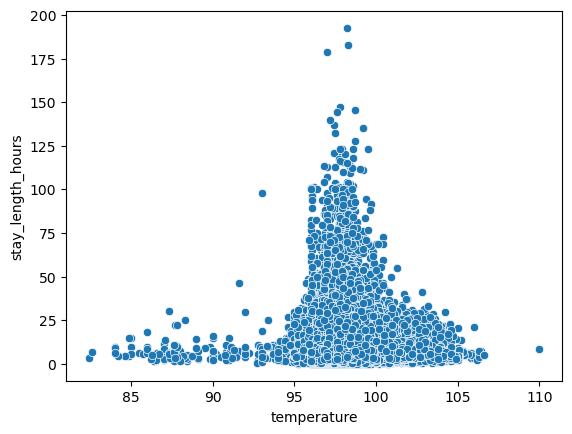

In [38]:
sns.scatterplot(x="temperature",
                    y="stay_length_hours",
                    data=df)

<Axes: xlabel='heartrate', ylabel='stay_length_hours'>

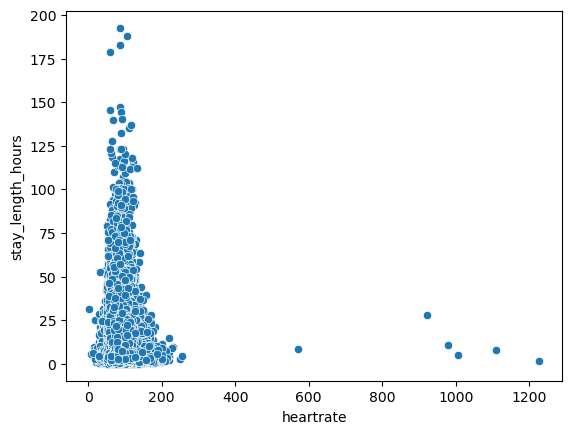

In [50]:
sns.scatterplot(x="heartrate",
                    y="stay_length_hours",
                    data=df)

<Axes: xlabel='resprate', ylabel='stay_length_hours'>

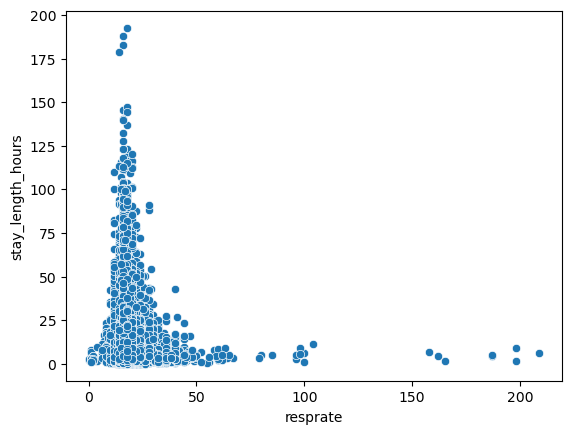

In [51]:
sns.scatterplot(x="resprate",
                    y="stay_length_hours",
                    data=df)

<Axes: xlabel='o2sat', ylabel='stay_length_hours'>

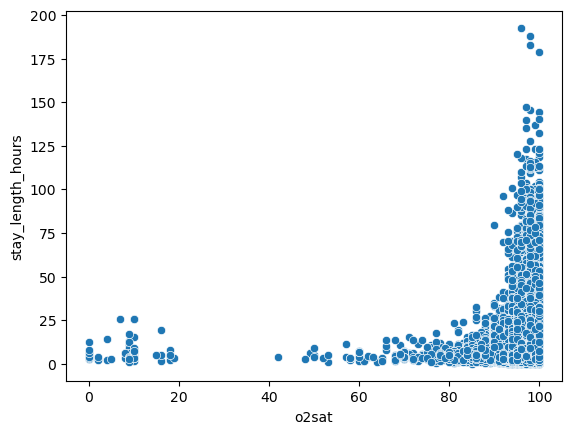

In [52]:
sns.scatterplot(x="o2sat",
                    y="stay_length_hours",
                    data=df)

<Axes: xlabel='sbp', ylabel='stay_length_hours'>

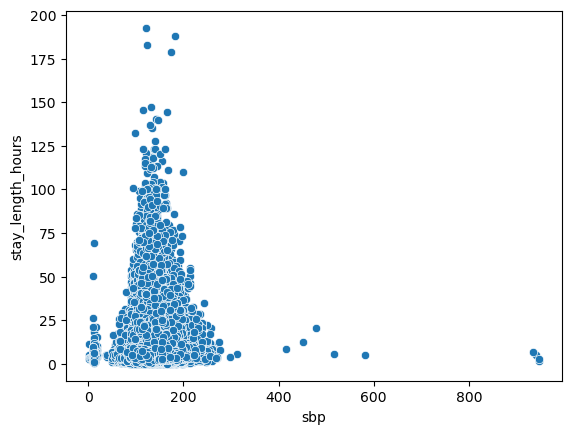

In [53]:
sns.scatterplot(x="sbp",
                    y="stay_length_hours",
                    data=df)

<Axes: xlabel='dbp', ylabel='stay_length_hours'>

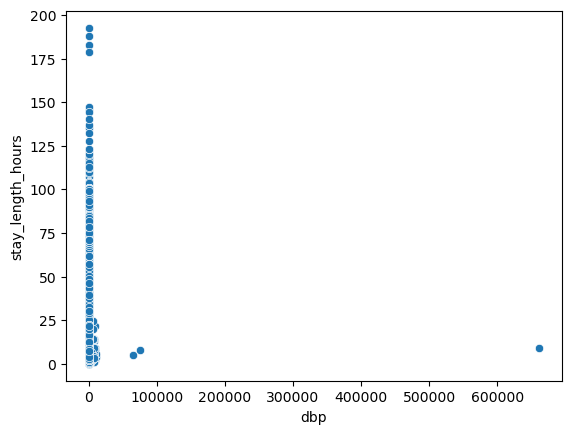

In [54]:
sns.scatterplot(x="dbp",
                    y="stay_length_hours",
                    data=df)